This notebook analyzes a single recording of EMG data from a test subject's biceps. 

# Step 1: Import and Format Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
in_data = '/home/cta/Documents/College/Skywalker Legacy/Sample Data/simple_emg_test.txt' # File containing raw EMG readings
df = pd.read_csv(in_data, header=4) # Read file and extract relevant data
emg_data = df[" EXG Channel 0"]
emg_data.rename({" EXG Channel 0":"c0"})
emg_data = emg_data.to_frame('c0')
time = np.linspace(1/200,10756/200,10756) # Add time series based on pre-existing knowledge about data properties
emg_data['time'] = time

This is what the EMG data looks like before filtration.

Text(0, 0.5, 'Potential Difference (uV)')

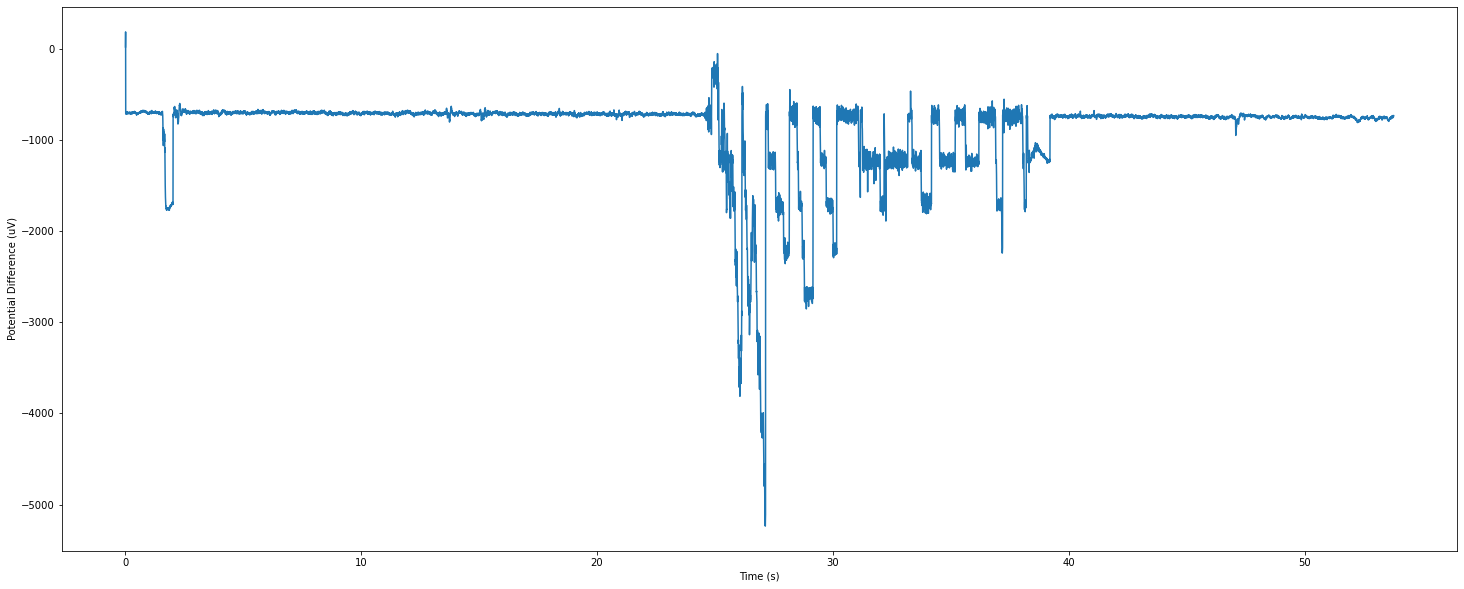

In [3]:
plt.rcParams["figure.figsize"] = (25,10)
plt.plot(emg_data['time'], emg_data['c0'])
plt.xlabel("Time (s)")
plt.ylabel("Potential Difference (uV)")

# Step 2: Filter Data

In [4]:
fs = 200 # Sample rate = 200 Hz. Pre-existing knowledge.

https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

In [5]:
# Define a bandpass filter to exclude low- and high-frequency components

from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [6]:
# Initialize bandpass filter, run EMG data through it, and add result to dataframe
lowcut = 5
highcut = 50
emg_butter = butter_bandpass_filter(emg_data['c0'],lowcut,highcut,fs,order=2)
emg_data['c0_filtered'] = emg_butter

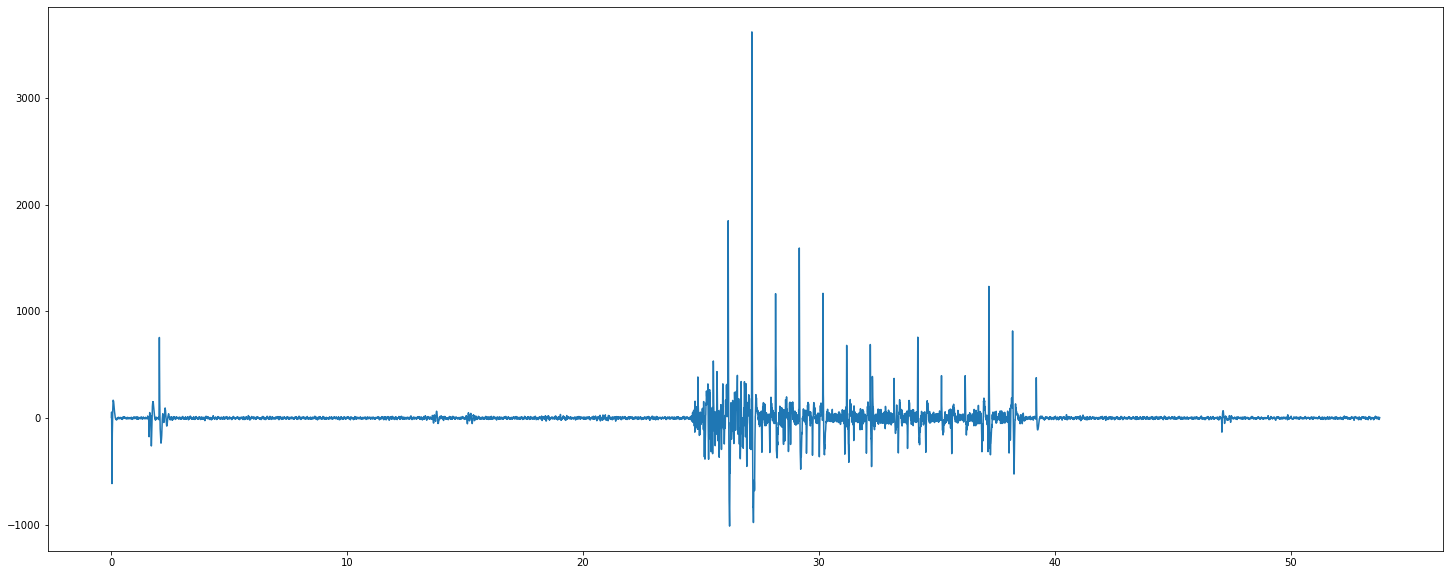

In [7]:
plt.plot(emg_data['time'], emg_data['c0_filtered'])

https://neurobb.com/t/openbci-why-are-1-50hz-bandpass-and-60hz-notch-filters-both-applied-by-default/23/2

# Test region

In [8]:
import mlxtend

# Step 3: Extract Features and Classify Segments

In [9]:
# calculates root mean square feature for a given data segment
def calc_rms(data):
    sq_sum = 0
    for i in range(0, len(data)):
        sq_sum += data[i]**2
    sq_sum /= len(data)
    sq_sum **= (1/2)
    return sq_sum

In [10]:
# calculates waveform length feature (as described in several articles on EMG) for a given data segment
def calc_wvlen(data):
    wv_len = 0
    for i in range(1,len(data)):
        wv_len += abs(data[i]-data[i-1])
    return wv_len

In [11]:
# label dataset based on pre-existing measurements (the muscle was either clenched or relaxed. It started relaxed, was clenched at t = 25.13 s, and relaxed again at t = 39.7 s)
t_clench = 25.13
t_clench -= 0.6 # I'm fudging the data a little because I don't think we labeled it right. Obviously, this is bad practice in real situations
t_relax = 39.7
t_stop = 53.97
offset = emg_data['time'].to_numpy()[-1] - t_stop
t_stop_true = t_stop+offset

In [12]:
t_stop_true

53.78

In [13]:
import random
import math

In [14]:
# takes in a start time and an end time (bounds) and returns the EMG data over that time segment. If no bounds are given, it generates some at random based on the window size.
def gen_point(emg_data,bounds=None,w_size=50, return_bounds=False):
    if bounds == None:
        t_start = math.floor(random.random()*(len(emg_data)-w_size+1)) # Generates number in range [0,10706]
        bounds = (t_start,t_start+w_size-1)
    time_seg = emg_data['time'][bounds[0]:bounds[1]+1].to_numpy()
    emg_seg = emg_data['c0_filtered'][bounds[0]:bounds[1]+1].to_numpy()
    
    label = 'ambiguous'
    if bounds[1]>t_stop_true*fs:
        label = 'out_of_bounds'
    elif bounds[1]<t_clench*fs or bounds[0]>t_relax*fs: # If the window is outside of the muscle activation time, label it
        label = 'relax'
    elif t_clench*fs<=bounds[0] and bounds[1]<=t_relax*fs: # If the window is within the muscle activation time, label it
        label = 'active'
    if return_bounds:   
        return emg_seg, label, bounds
    else:
        return emg_seg, label

Some example code showing how these functions can be used to select regions within the dataset

In [15]:
ts = 53.54
n = 24
bounds = np.empty((n,2))
for i in range(0,n):
    emg_seg, label, bounds[i] = gen_point(emg_data, w_size=200, return_bounds=True)

In [16]:
bounds[0]/200

array([3.56 , 4.555])

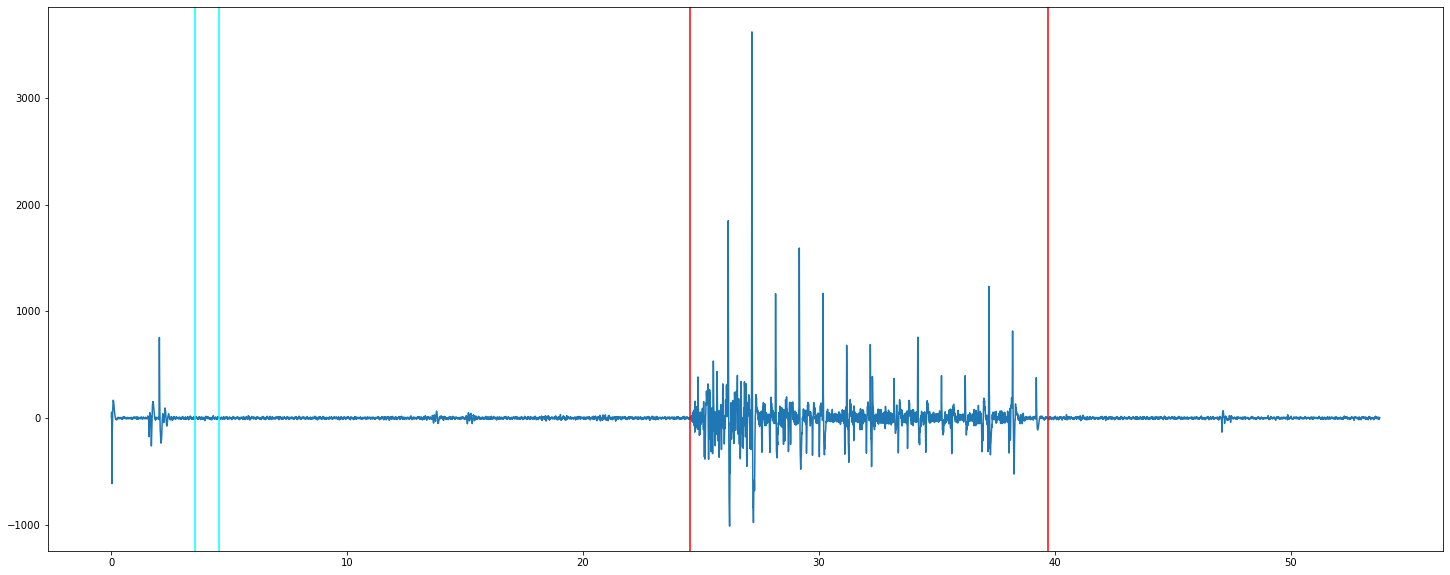

In [17]:
plt.rcParams["figure.figsize"] = (25,10)
plt.plot(emg_data['time'], emg_data['c0_filtered'])
plt.axvline(x=t_clench,color='red')
plt.axvline(x=t_relax,color='red')

n_test = 0
b = bounds[n_test]

plt.axvline(x=b[0]/fs,color='cyan')
plt.axvline(x=b[1]/fs,color='cyan')

The real-deal code that does ML on this dataset

In [41]:
# normalizes a given array based on its own elements
def norm_arr_simple(arr):
    arr = np.array(arr)
    yardstick = max(abs(arr))
    new_arr = np.empty(np.shape(arr))
    for i in range(0,len(arr)):
        new_arr[i] = arr[i]/yardstick
    return new_arr

In [42]:
# given a dataset and an array of functions that compute features from datasets of that type, computes normalized features for the given dataset
def extract_norm_features(data,f_arr):
    data_features = np.empty((len(data),len(f_arr)))
    for i in range(0,len(data)):
        for j in range(0,len(f_arr)):
            data_features[i][j] = f_arr[j](data[i])
    for i in range(0,len(data_features[0])):
        data_features[:,i] = norm_arr_simple(data_features[:,i])
    return data_features

In [43]:
def get_bounds(X, bounds, x_target): # also converts bounds to integers
    idx = find_point_idx(X, x_target)
    b = bounds[idx]
    b = (int(b[0]),int(b[1]))
    return b

In [44]:
def find_point_idx(X, x_target):
    idx = None
    for i in range(0,len(X)):
        if np.all(x_target==X[i]):
            idx = i
    return idx

In [45]:
from sklearn.model_selection import train_test_split
from sklearn import svm

In [46]:
# get points for classification

ws = 50 # window size (units of 5 ms; ws = 100 --> window size of 0.5 seconds)
n_points = 128 # number of points

X = np.zeros((n_points,ws))
y = np.empty(n_points,dtype=object)
bounds = np.empty((n_points,2))

for i in range(0,n_points): # generates random points of the given window size
    emg_seg, label, b = gen_point(emg_data,w_size=ws,return_bounds=True)
    X[i] = emg_seg
    y[i] = label
    bounds[i] = b

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=24) # divide into training and testing data

f_list = [calc_rms, calc_wvlen]
X_train_points = extract_norm_features(X_train,f_list) # extract features from training data

num_dict = {"relax":0, "ambiguous":1,"active":2}
y_train_int = np.zeros(len(y_train),dtype=int)
for i in range(0,len(y_train)):
    y_train_int[i] = num_dict[y_train[i]]
y_test_int = np.zeros(len(y_test),dtype=int)
for i in range(0,len(y_test)):
    y_test_int[i] = num_dict[y_test[i]]

clf_1 = svm.LinearSVC().fit(X_train_points,y_train_int) # create classifier based on training data
#clf_1 = svm.SVC(C=0.5,kernel='linear')
#clf_1.fit(X_train_points, y_train)

In [48]:
# classifies points in testing data
X_test_points = extract_norm_features(X_test,f_list)
pre = clf_1.predict(X_test_points)

# creates dictionary to label points with colors
c_dict = {'relax':'blue','active':'orange','ambiguous':'red'}

col_arr_train = np.empty(np.shape(y_train),dtype='object') # labels training points with colors
for i in range(0,len(col_arr_train)):
    col_arr_train[i] = c_dict[y_train[i]]
    
col_arr_test = np.empty(np.shape(y_test),dtype='object') # labels test points with colors
for i in range(0,len(col_arr_test)):
    col_arr_test[i] = c_dict[y_test[i]]

In [49]:
a = np.zeros(len(X_test))
for i in range(0,len(a)):
    a[i] = find_point_idx(X,X_test[i])

In [50]:
a

array([ 19., 110.,  14.,  52., 109.,  93.,  62.,  85.,  40.,  49.,  91.,
       122.,  83.,  61.,  38.,  29.,  44.,   9.,  59., 112.,  20.,  69.,
        88.,  30.,  53.,  76.,  75., 107.,   2.,  13.,  50., 115., 104.,
       119.,  48.,  37.,  83., 102.,  31.,  51.,  22.,  24.,  67.])

In [51]:
extract_norm_features(np.array([X_test[28]]),[calc_rms,calc_wvlen])

array([[1., 1.]])

In [52]:
X[2]

array([-220.75276065, -247.36837073, -252.23868283, -152.05799036,
        -88.86911917, -129.55110765, -149.86287189,  -88.21395356,
        -40.27709088,  -68.51824018,  -55.32008489,   31.62801919,
         49.88590877,  -21.49529763,  -54.56536344,    6.77876509,
         47.69312677,    9.22235356,  -18.84377569,   50.73933629,
        111.37302627,   33.17032564,  -35.81117272,    3.28594836,
         29.64613319,   -3.72558485,  -24.61546711,   24.86688371,
         80.89246491,   13.48144092,  -75.15527732,  -18.61007505,
         73.55155114,   34.25789981,  -53.41275164,   -8.09954589,
         96.49732876,   76.6949674 ,  -45.74584081,  -85.73698474,
         -7.71083517,   39.7223404 ,   13.80401685,  -42.9725143 ,
        -70.09953717,   11.92537349,   80.02275701,  -23.53698463,
       -159.4529868 , -204.44459169])

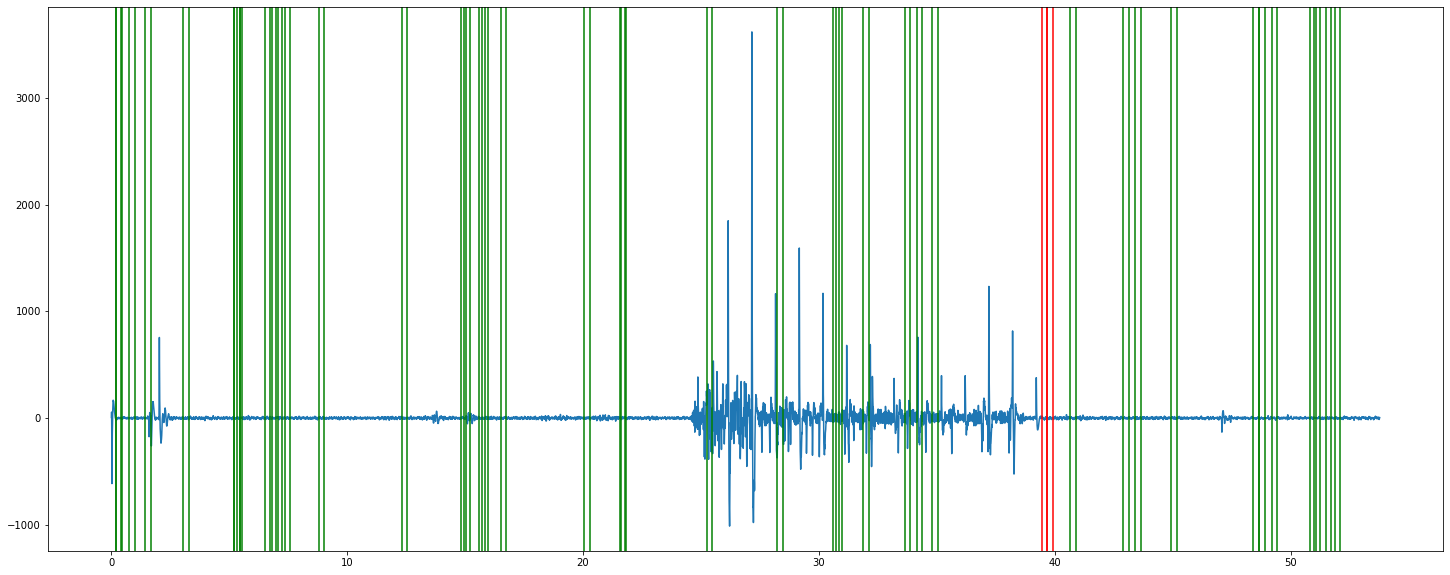

In [53]:
c_corr = (y_test_int == clf_1.predict(X_test_points))

plt.plot(emg_data['time'], emg_data['c0_filtered'])
col = "green"

for i in range(0, len(X_test)): # iterate over array of bounds and plot them
    b = get_bounds(X,bounds,X_test[i])
    
    if c_corr[i]:
        col = "green"
    else:
        col = "red"
        
    plt.axvline(x=b[0]/fs,color=col)
    plt.axvline(x=b[1]/fs,color=col)

In [54]:
bounds[20]

array([2462., 2511.])

In [55]:
l = get_bounds(X, bounds, X[20])
l

(2462, 2511)

In [56]:
X_test[0]

array([ -6.41226007,  -4.9359556 ,  -0.67796254,   3.65045922,
         2.56578036,  -0.13780256,   3.5147695 ,   4.10239197,
        -1.57737062,  -4.11349847,  -4.58769936,  -7.17378632,
        -7.61127289,  -4.96255793,  -4.14823431,  -1.75218669,
         5.37012582,   7.72657232,   4.89986054,   4.3074645 ,
         0.48567722,  -5.62543838,  -2.85986287,   0.47881355,
        -6.51377883, -12.34738492,  -8.19498058,  -3.68199412,
        -5.46769069,  -4.56837201,   1.21684306,   3.20271149,
         1.27663567,   1.25061572,   1.82705966,   3.61289906,
         9.47108224,   7.24962357,  -4.93669655,  -7.29879253,
         0.23314993,  -0.05138691,  -1.26508279,   7.20847062,
         9.99411972,   4.39553039,   2.33912036,   0.09196845,
        -3.03309109,  -0.08264306])

In [57]:
pre==y_test_int

array([ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

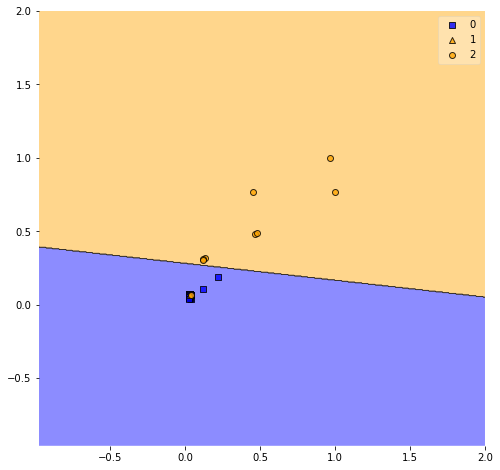

In [63]:

from mlxtend.plotting import plot_decision_regions
fig = plt.figure(figsize=(8,8))

s = 1
Xs = None
ys = None
if s:
    Xs = X_test_points
    ys = y_test_int
else:
    Xs = X_train_points
    ys = y_train_int

ax = plot_decision_regions(Xs, ys, clf=clf_1,colors="blue,orange,orange")
#ax.set_xlim([0,1.5])
#ax.set_ylim([0,1.5])

In [59]:
clf_1.score(X_test_points,y_test_int) # scores accuracy of classifier on testing data

0.9534883720930233

In [60]:
clf_1.predict(X_test_points)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0])

In [61]:
y_test_int

array([0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0])

In [39]:
# find indices of all misclassified points
# find bounds for all points
# plot bounds on signal; incorrectly classified points in red, correctly classified points in blue

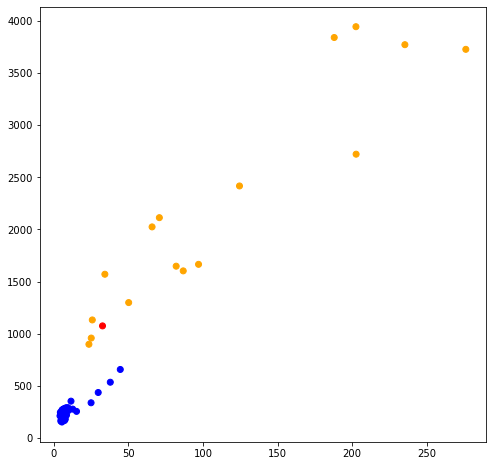

In [40]:
# plots training data
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
#ax.scatter(a,b,c=col_arr)
ax.scatter(X_train_points[:,0],X_train_points[:,1],c=col_arr_train)

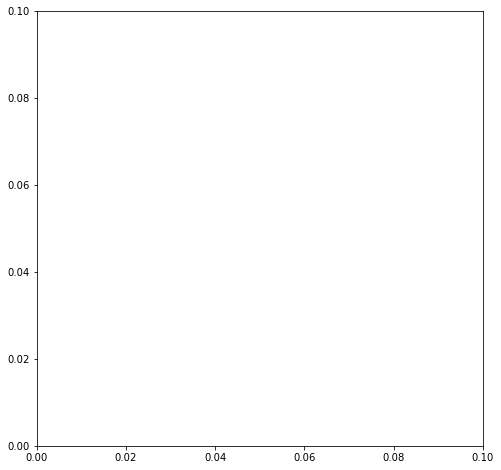

In [108]:
# zoomed-in view of training data around low (x,y)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.set_xlim([0,0.1])
ax.set_ylim([0,0.1])
ax.scatter(X_train_points[:,0],X_train_points[:,1],c=col_arr_train)

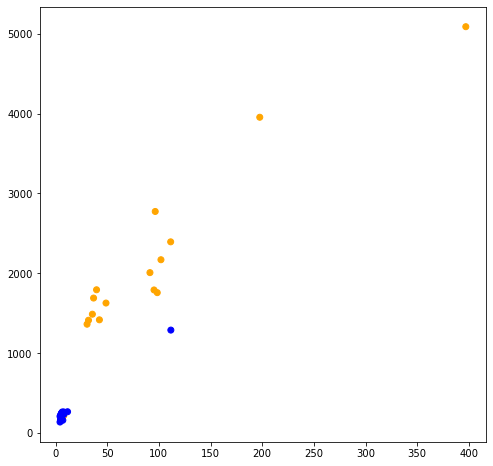

In [109]:
# plots testing data
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
#ax.scatter(a,b,c=col_arr)
ax.scatter(X_test_points[:,0],X_test_points[:,1],c=col_arr_test)

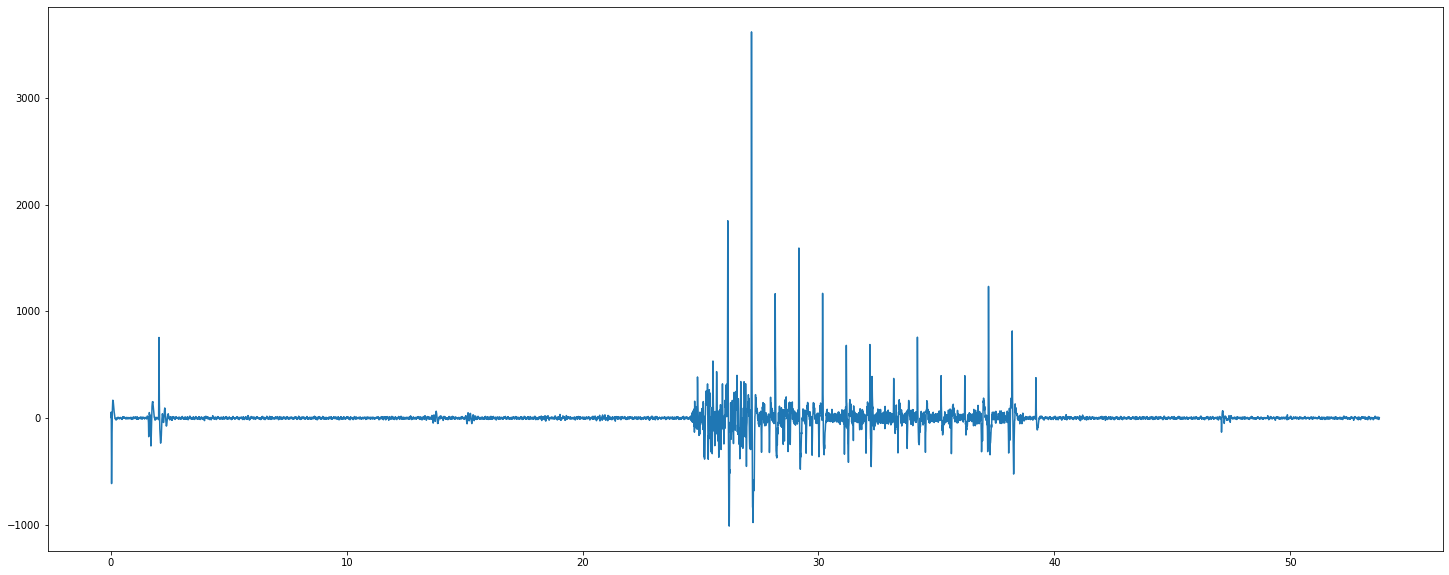

In [51]:
plt.plot(emg_data['time'], emg_data['c0'])

In [52]:
# graphs true labels of dataset

ws = 500
labels_arr_true = np.zeros(shape=len(emg_data['c0'])-len(emg_data['c0'])%50) # array to store classified EMG data
glab_dict = {'relax':0,'ambiguous':.5,'active':1}# dictionary to translate labels into numbers for graphing purposes

for i in range(0,len(emg_data['c0'])-ws,ws):
    b_left = i
    b_right = i+ws-1
    raw_point, label = gen_point(emg_data,bounds=(b_left,b_right),w_size=ws) # should I have gen_point take the whole dataset?
    raw_point = np.reshape(raw_point,(1,-1))
    
    labels_arr_true[b_left:b_right+1] = [glab_dict[label]]*ws

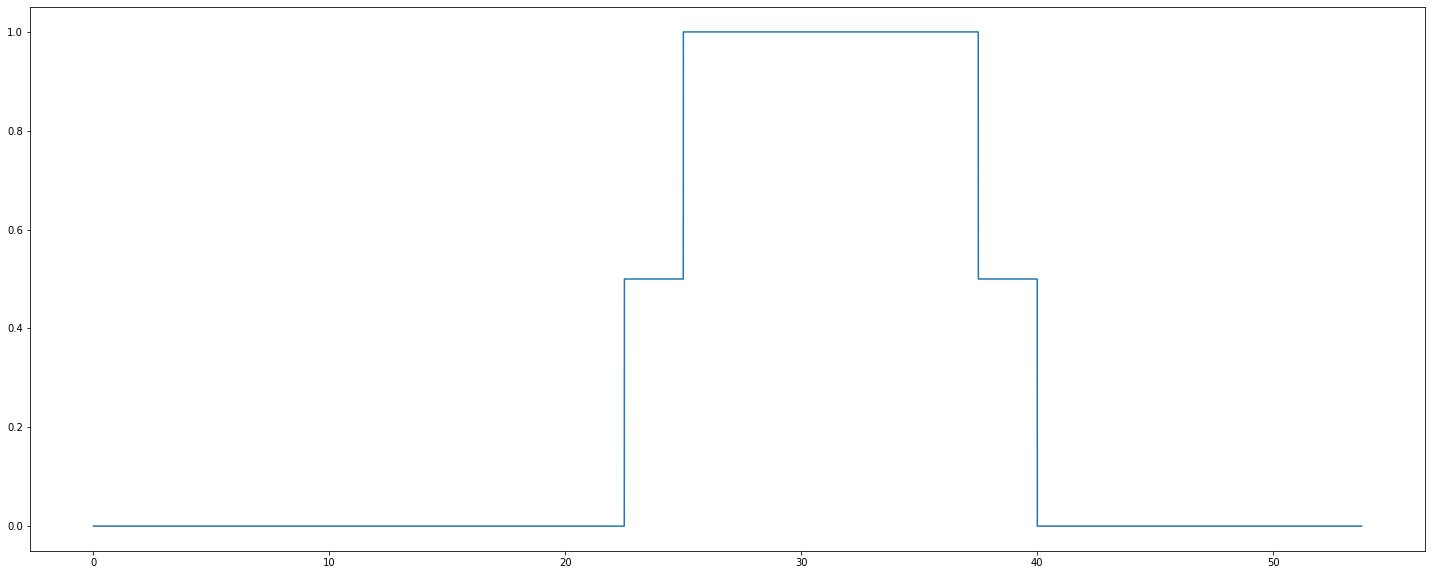

In [53]:
plt.plot(emg_data['time'][:-6],labels_arr_true)

In [54]:
# graphs classified labels of dataset

ws = 500
labels_arr_clf = np.zeros(shape=len(emg_data['c0'])-len(emg_data['c0'])%50) # array to store classified EMG data
glab_dict = {'relax':0,'ambiguous':.5,'active':1} # dictionary to translate labels into numbers for graphing purposes

# chops emg data into points of len 50, then turns those into two-feature points
l = len(emg_data['c0'])
emg_points = np.zeros(shape=(int((l-l%ws)/ws),ws))

for i in range(0,l-ws,ws):
    emg_points[int(i/ws)] = emg_data['c0'][i:i+ws]

proc_points = extract_norm_features(emg_points,f_list)
labels = clf_1.predict(proc_points)
for i in range(0,len(labels)):
    labels_arr_clf[i*ws:(i+1)*ws] = [glab_dict[labels[i]]]*ws
    
# for i in range(0,len(emg_data['c0'])-ws,ws):
#     b_left = i
#     b_right = i+ws-1
#     raw_point, label = gen_point(emg_data,bounds=(b_left,b_right),w_size=ws); label = None # should I have gen_point take the whole dataset?
#     raw_point = np.reshape(raw_point,(1,-1))
    
#     # process point
#     proc_point = np.reshape(extract_norm_features(raw_point,f_list),(1,-1))
#     label = clf_1.predict(proc_point)[0]
    
#     labels_arr_clf[b_left:b_right+1] = [glab_dict[label]]*ws

In [55]:
labels

array(['relax', 'relax', 'relax', 'relax', 'relax', 'relax', 'relax',
       'relax', 'relax', 'relax', 'active', 'active', 'active', 'active',
       'active', 'relax', 'relax', 'relax', 'relax', 'relax', 'relax'],
      dtype='<U9')

In [56]:
emg_points[-1]

array([ -2.03477219,   4.14827032,  13.96219138,  15.49710853,
        13.93339902,  15.58341788,  11.24949146,   1.82611905,
        -3.31938697,  -3.09961102,  -3.90945021,  -7.81557163,
        -9.58496632,  -9.77453761,  -9.12620682,  -5.38716471,
        -4.930797  ,  -9.37610965,  -8.38485868,  -5.34256296,
        -6.87713488,  -7.89877526,  -7.4463931 ,  -8.3638819 ,
        -6.21538193,   2.95937396,   7.7977627 ,   3.1146263 ,
         3.39783699,   8.10872382,   4.69004634,   0.02330909,
        -1.15019932,  -2.63485359,   2.43235197,   6.4663665 ,
        -1.62516819,  -4.5673947 ,   2.01158568,   0.94913063,
        -4.10865472,   0.29174847,   6.13496536,   5.64062796,
         7.28097924,   7.46058125,   2.40302029,   2.87481301,
         9.40082297,   9.25115999,   0.17812271,  -4.50599404,
         0.90295631,   3.00810187,  -5.30178766,  -7.63358612,
        -2.2616517 ,  -2.64414631,  -0.6900265 ,   5.07784286,
         3.70113584,   4.53252032,   6.30611176,  -0.64

In [57]:
extract_norm_features(raw_point,f_list)

array([[1., 1.]])

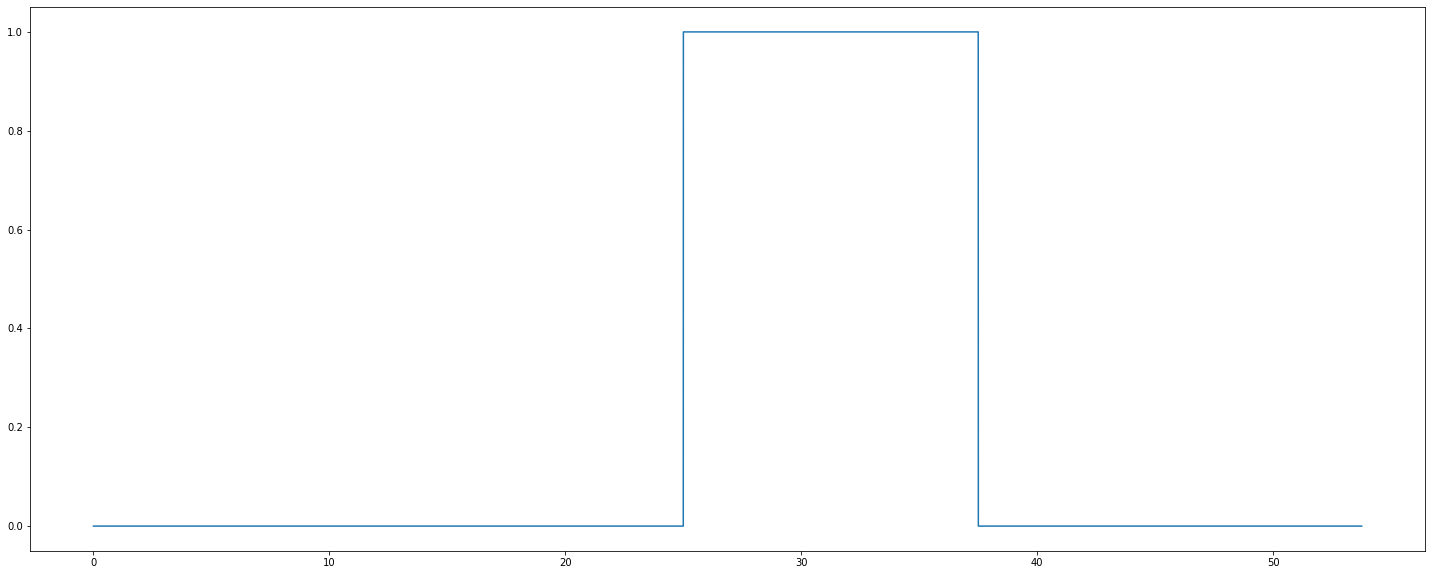

In [58]:
plt.plot(emg_data['time'][:-6],labels_arr_clf)

In [59]:
a[1:3] = [2]*2

In [60]:
a

array([[0.24307676, 0.34268032]])